矩阵乘法：A(mxk) * B(kxn) = C(mxn)

采用了三种实现方式:
1.global memory
2.share memory
3.register

在cuda计算中，设备分为host和device，也就是cpu和gpu；
首先分别在内存空间和显存空间声明地址，并将cpu中定义的数据送入gpu：

In [ ]:
    cudaMalloc((void **)&D_A, m * k * sizeof(float));
    cudaMalloc((void **)&D_B, m * k * sizeof(float));
    cudaMalloc((void **)&D_C, m * k * sizeof(float));

    A = (float*)malloc(m * k * sizeof(float));
    B = (float*)malloc(k * n * sizeof(float));
    C = (float*)malloc(m * n * sizeof(float));

    cudaMemcpy(D_A, A, m * k * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(D_B, B, k * n * sizeof(float), cudaMemcpyHostToDevice);

要想使用cuda计算显存中的数据，首先要编制线程网：grid(block(thread))，多个线程组成一个block，多个block组成grid。cuda会根据block和grid的大小，组织起一个线程网，并行的计算数据。

In [ ]:
    im3 blockSize;
    dim3 gridSize;
    blockSize.x = BSIZE;
    blockSize.y = BSIZE;
    gridSize.x = (m + blockSize.x - 1) / blockSize.x;
    gridSize.y = (n + blockSize.y - 1) / blockSize.y;

cuda会根据你所编写的核函数，让线程网中的每一个线程都去运行核函数，接下来需要编写在gpu中运行的核函数(__global__ kernel()):

In [ ]:
__global__ void mat_times(float *A, float *B, float *C, int m, int n, int k){

    int nRow = blockIdx.y * blockDim.y + threadIdx.y;
    int nCol = blockIdx.x * blockDim.x + threadIdx.x;
    float val = 0;
    //从显存中取数据进行计算
    for(int i=0;i<k;i++){
        val += A[nRow * k + i] * B[n * i + nCol];
    }
    C[nRow * n + nCol] = val;
}

用每个线程自身的属性定位到矩阵中，将AB矩阵的数据取出进行计算；
注意AB矩阵都放置于显存中，计算时需将数据从global memory取到计算单元SP进行计算；
每个线程都会取k次A矩阵和k次B矩阵，一共mxn个线程，执行2mnk次读操作和mn次写操作

但gpu的指令以每个warp为最小单位，warp 包含 32 个 thread，Global Memory 的读/写访问均是以 32 Byte 为transaction单元。 对于 1 个 warp 中的 32 个 thread。 在每 1 次循环中, 需要读取矩阵 A 同一个元素以及矩阵 B 连续的 32 个元素(A的同一行乘以B的不同列)，也就是4Byte A矩阵和32x4 ByteB矩阵，需要1+4个transaction.

所以读操作并没有2mnk次，而是2mnk/32x5。
写操作同理，一个warp需要写32个4byte数据，但global一个transaction只能写32Byte，所以一个warp要写4个transaction，因此写操作也没有mn次，而是mn/32*4次。

而一个block里面可以使用同一个share memory，这样就不用取显存中取数据了。
可以将blocksize x blocksize大小的A矩阵和B矩阵数据拿到shareM中，一个block中的所有线程都在里面取数据；

In [ ]:
__global__ void mat_times_share(float *A, float *B, float *C, int m, int n, int k){
  int nRow = blockIdx.y * blockDim.y + threadIdx.y;
  int nCol = blockIdx.x * blockDim.x + threadIdx.x;

  __shared__ float Shared_A[BSIZE][BSIZE];
  __shared__ float Shared_B[BSIZE][BSIZE];

  int nIter = (k + BSIZE - 1) / BSIZE;
  float tval = 0;

  for(int i=0;i<nIter;i++){
    Shared_A[threadIdx.y][threadIdx.x] = A[nRow * k + i * BSIZE + threadIdx.x];
    Shared_B[threadIdx.y][threadIdx.x] = B[(i * BSIZE + threadIdx.y) * n + nCol];

    __syncthreads();

    for(int j=0;j<BSIZE;j++){
      tval += Shared_A[threadIdx.y][j] * Shared_B[j][threadIdx.x];
    }

    __syncthreads();
  }
  C[nRow * n + nCol] = tval;
}

一个block里面的线程从shareM中取数据可以算出小半行乘以小半列的结果，然后滑动shareM，取下一个小半行和小半列来计算结果，就相当于每次算blocksize那么大的面积，慢慢算完整行乘以整列。


在该情况下，取操作就变成了从显存中取到shareM中，从ShareM中取到SP中，写操作则不变。

改用shareM可以利用shareM的高速度进行重复取，减少了在显存中的重复取操作。但这种做法还是没有改变取一个数据算一个结果的现状，取数据很慢，算数据很快；

因此可以考虑一个线程算多个数据

In [ ]:
__global__ void mat_times_share_reg(float *A, float *B, float *C, int m, int n, int k){
    
  const int q = Q;
  int nRow = blockIdx.y * blockDim.y * q + threadIdx.y;
  int nCol = blockIdx.x * blockDim.x + threadIdx.x;

  __shared__ float Share_A[1][1];
  __shared__ float Share_B[1][1];

  int nIter = (k + BSIZE - 1) / BSIZE;
  float tval[q] = {0};

  for(int i=0;i<nIter;i++){

    for(int p=0; p<q; p++){
      Share_A[threadIdx.y+BSIZE/q*p][threadIdx.x]=A[(nRow+BSIZE/q*p)*k+i*BSIZE+threadIdx.x];
      Share_B[threadIdx.y+BSIZE/q*p][threadIdx.x]=B[(i*BSIZE+threadIdx.y+BSIZE/q*p)*n+nCol];
    }

    __syncthreads();

    for(int j=0;j<BSIZE;j++){

      for(int p=0; p<q; p++){
        tval[p] += Share_A[threadIdx.y+BSIZE/q*p][j] * Share_B[j][threadIdx.x];
      }
    }

  __syncthreads();

  }

  for(int p=0; p<q; p++){
    C[(nRow+BSIZE/1*p)*n+nCol]=tval[p];
  }
}

同样取blocksize大小的shareM，但一个线程负责算Q个结果。
在编织线程网的时候，让网格的高度只有所算矩阵部分的一半或者更小，这样每个线程都要负责算当前单元以及下面单元的结果。

In [ ]:
dim3 blockSize;
dim3 gridSize;
blockSize.x = BSIZE;
blockSize.y = BSIZE;
gridSize.x = (m + blockSize.x - 1) / blockSize.x;
gridSize.y = (n + blockSize.y - 1) / blockSize.y;
blockSize.y = BSIZE / Q;

计算时，从shareM中取数个A矩阵元素和B矩阵的一个元素；
这样就提高了访存比，可以显著提升性能。


实验分析：


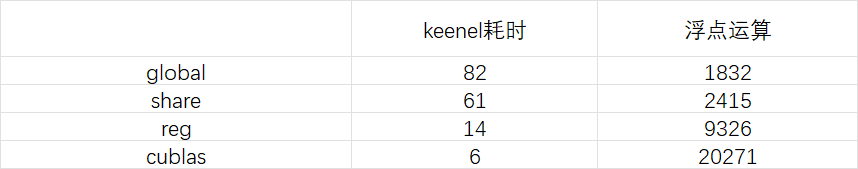

寄存器方法取得了最高的性能，达到了cublas的46%。

同时，还对reg方法进行了消融实验，观察提升访存比对计算性能的提升存在的关系：

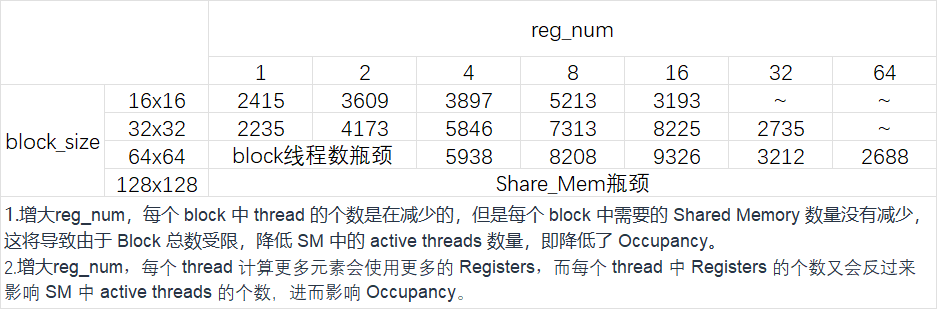

总的来说，影响计算性能的不仅有SM内的线程数量，还有单个线程所使用的资源，线程数量少的话或者单个线程使用资源多的话，active warp数量就少。
而线程数量多，资源使用少的话，又会出现访存延迟。

实际上还能继续提升blocksize观察性能峰值，但设置到128时，会出现shareM不足的错误，这个问题应该可以解决，后续还能再探索。


除此之外，后面还可以在考虑寄存器bank冲突，是旷世提出的，可以对寄存器进行分块。
其他方法还有什么数据预取，向量读取什么的。